In [205]:
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization,Normalization,Dense,ReLU,GaussianDropout,Convolution2D,InputLayer,Lambda, Add, Convolution1D, Dropout, LeakyReLU
from tensorflow.keras.losses import MeanSquaredError,MeanAbsoluteError,Huber
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.metrics import RootMeanSquaredError
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [105]:
df = pd.read_csv("../data/second-hand-cars/train.csv")
df.shape

(1000, 12)

In [106]:
df.columns

Index(['v.id', 'on road old', 'on road now', 'years', 'km', 'rating',
       'condition', 'economy', 'top speed', 'hp', 'torque', 'current price'],
      dtype='object')

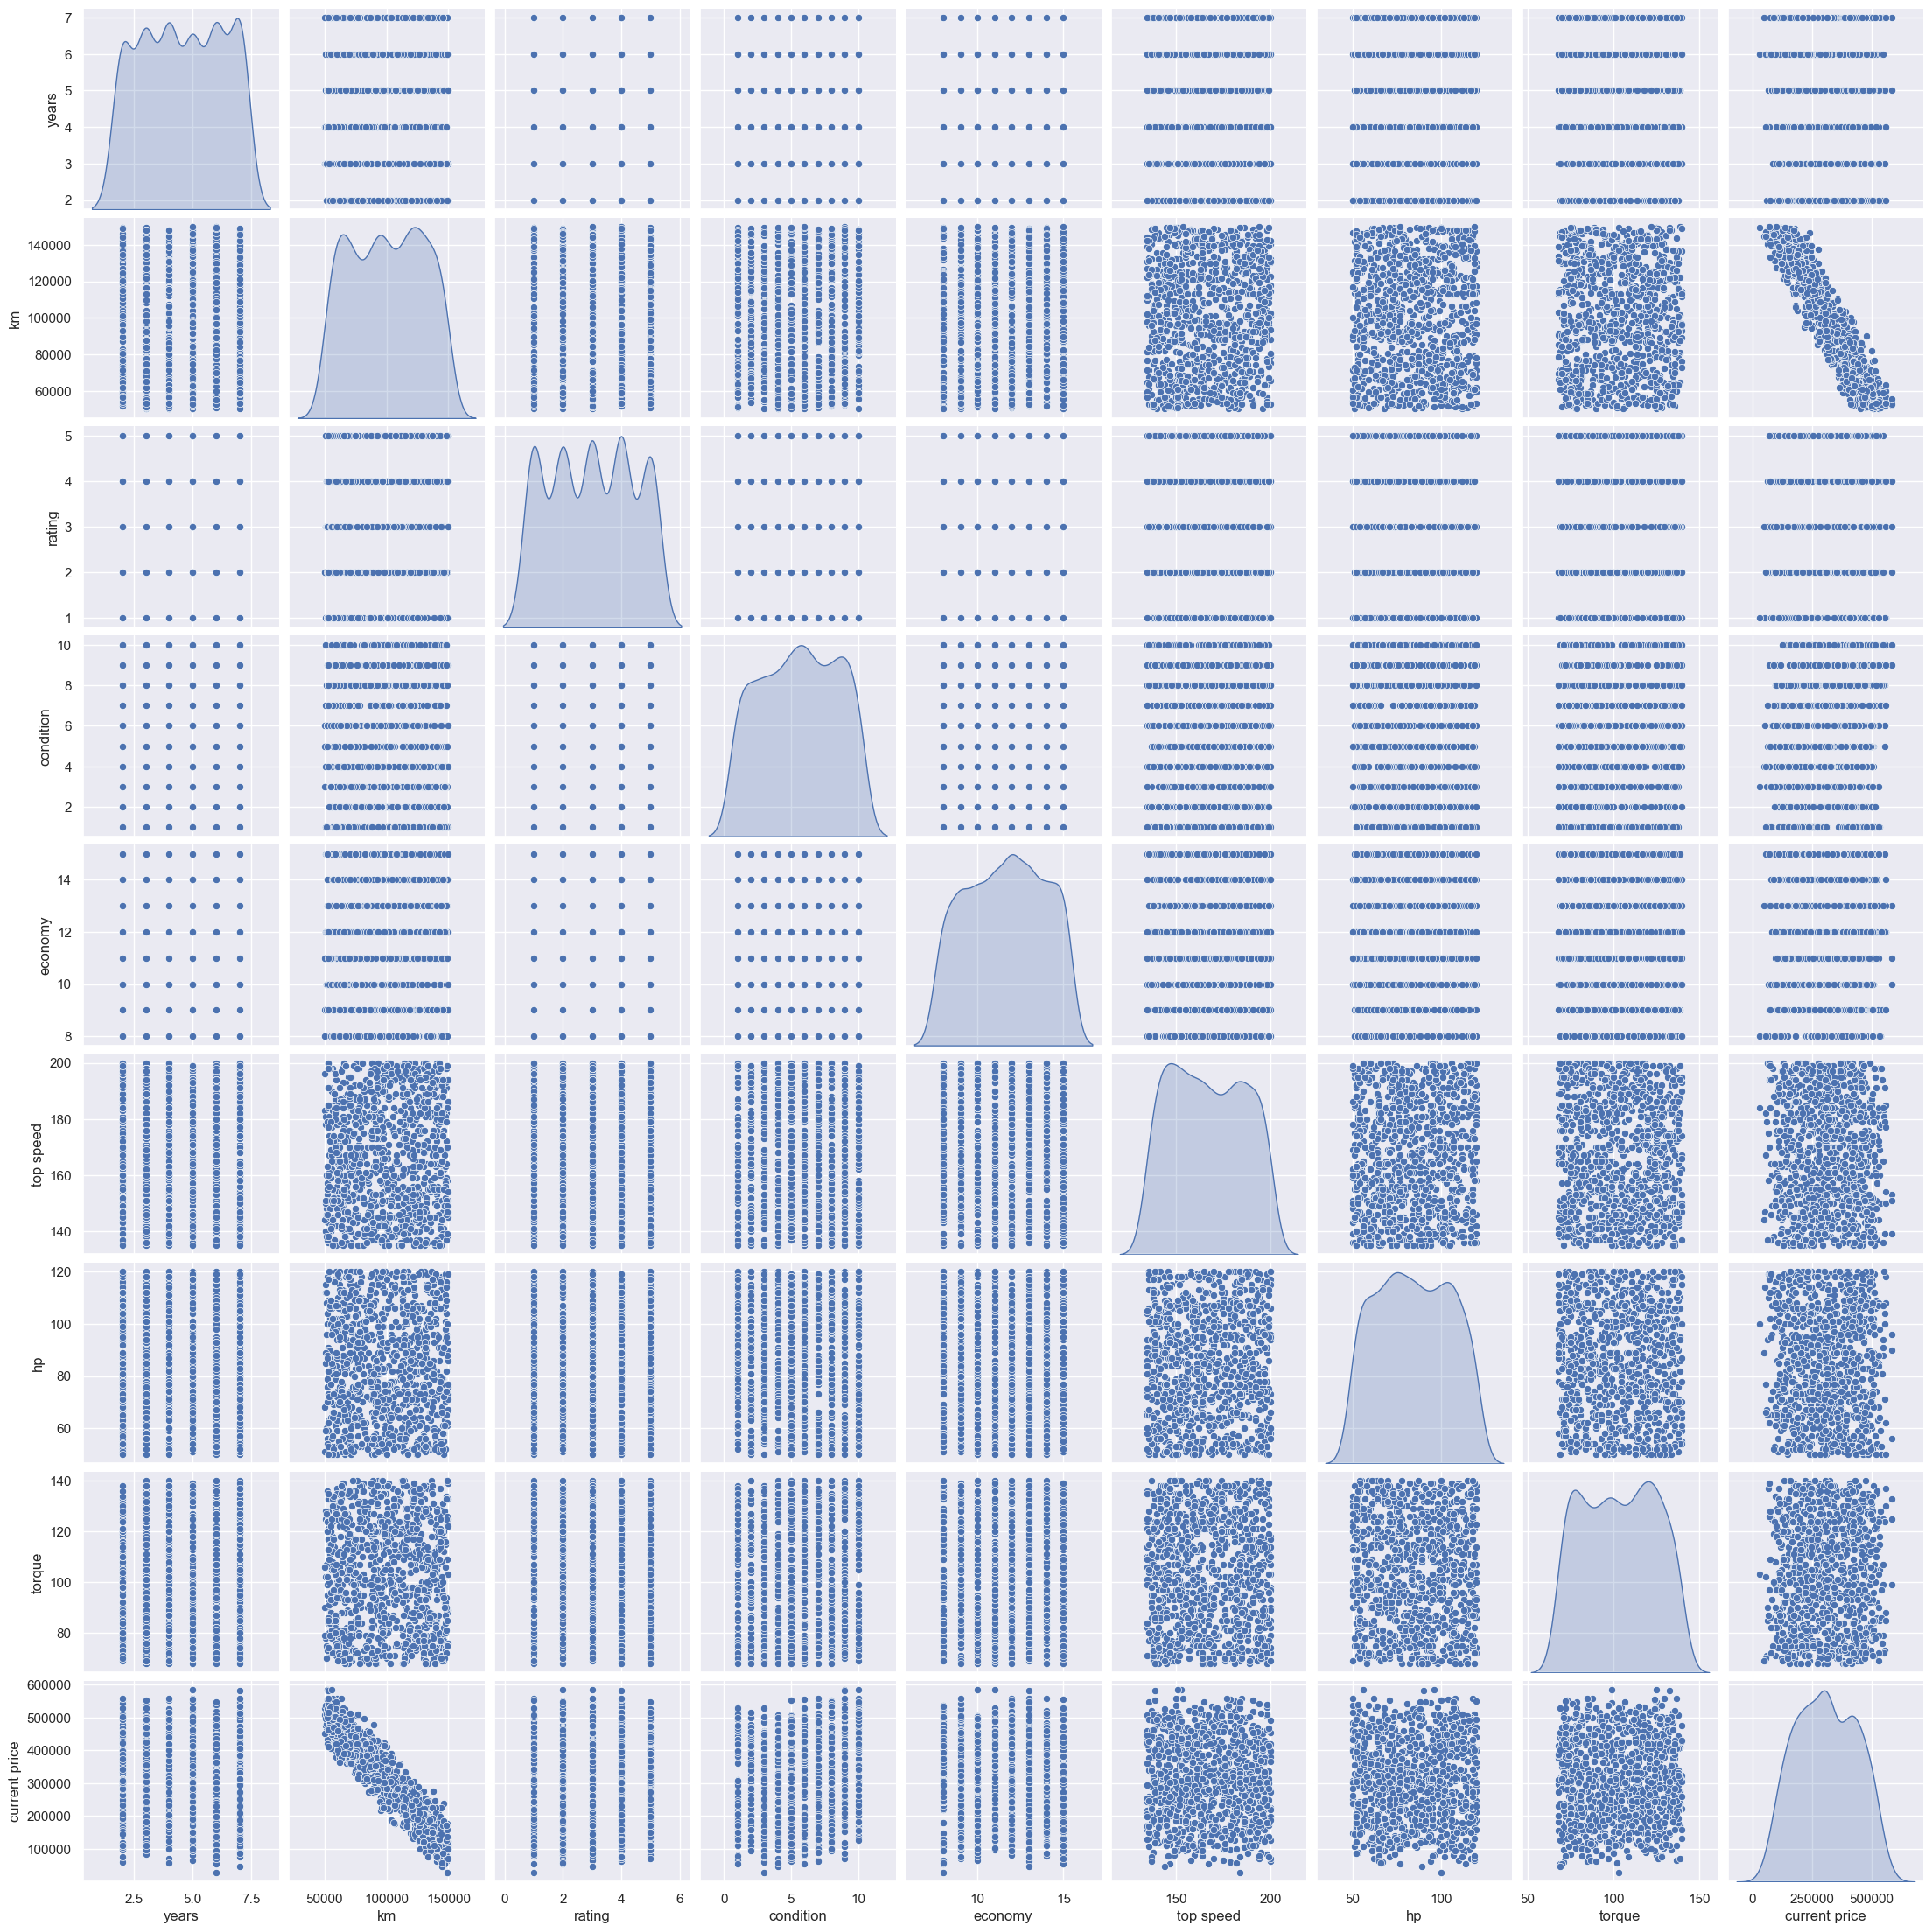

In [107]:
sns.pairplot(df[['years', 'km', 'rating','condition', 'economy', 'top speed', 'hp', 'torque', 'current price']],diag_kind="kde")

In [108]:
df.describe()

,v.id,on road old,on road now,years,km,rating,condition,economy,top speed,hp,torque,current price
count,1000.000000,1000.000000,1000.0000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.00000,1000.000000,1000.00000
mean,500.500000,601648.286000,799131.3970,4.561000,100274.430000,2.988000,5.592000,11.625000,166.89300,84.54600,103.423000,308520.24250
std,288.819436,58407.246204,57028.9502,1.719079,29150.463233,1.402791,2.824449,2.230549,19.28838,20.51694,21.058716,126073.25915
min,1.000000,500265.000000,700018.0000,2.000000,50324.000000,1.000000,1.000000,8.000000,135.00000,50.00000,68.000000,28226.50000
25%,250.750000,548860.500000,750997.7500,3.000000,74367.500000,2.000000,3.000000,10.000000,150.00000,67.00000,85.000000,206871.75000
50%,500.500000,601568.000000,798168.0000,5.000000,100139.500000,3.000000,6.000000,12.000000,166.00000,84.00000,104.000000,306717.75000
75%,750.250000,652267.250000,847563.2500,6.000000,125048.000000,4.000000,8.000000,13.000000,184.00000,102.00000,121.000000,414260.87500
max,1000.000000,699859.000000,899797.0000,7.000000,149902.000000,5.000000,10.000000,15.000000,200.00000,120.00000,140.000000,584267.50000


In [185]:
df_constant = tf.constant(df,dtype=tf.float32)
df_constant

<tf.Tensor: shape=(1000, 12), dtype=float32, numpy=
array([[1.000000e+00, 5.356510e+05, 7.981860e+05, ..., 7.300000e+01,
        1.230000e+02, 3.513180e+05],
       [2.000000e+00, 5.919110e+05, 8.610560e+05, ..., 7.400000e+01,
        9.500000e+01, 2.850015e+05],
       [3.000000e+00, 6.869900e+05, 7.707620e+05, ..., 5.300000e+01,
        9.700000e+01, 2.153860e+05],
       ...,
       [9.980000e+02, 6.463440e+05, 8.427330e+05, ..., 1.130000e+02,
        8.900000e+01, 4.058710e+05],
       [9.990000e+02, 5.355590e+05, 7.324390e+05, ..., 1.120000e+02,
        1.280000e+02, 7.439800e+04],
       [1.000000e+03, 5.901050e+05, 7.797430e+05, ..., 9.900000e+01,
        9.600000e+01, 4.149385e+05]], dtype=float32)>

In [206]:
X, y = df_constant[:,3:-1],tf.expand_dims(df_constant[:,-1], axis=1)
TRAIN_RATIO = 0.8
TEST_RATIO = 0.1
VAL_RATIO = 0.1
DATASET_SIZE = len(X)
print(f"X.shape => {X.shape}")
print(f"y.shape => {y.shape}")

X.shape => (1000, 8)
y.shape => (1000, 1)


In [207]:
train_size = int(DATASET_SIZE * TRAIN_RATIO)
val_size = int(DATASET_SIZE * VAL_RATIO)
test_size = DATASET_SIZE - train_size - val_size # int(DATASET_SIZE * TEST_RATIO)

# Split the data into training, validation, and test sets
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

train_dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train)).shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test,y_test)).shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val,y_val)).shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

print(f"The dataset has been split into training, validation, and test sets with the following ratios: \n"
      f"- Training set: {train_size} samples ({TRAIN_RATIO*100}% of the dataset)\n"
      f"- Validation set: {val_size} samples ({VAL_RATIO*100}% of the dataset)\n"
      f"- Test set: {test_size} samples ({TEST_RATIO*100}% of the dataset)\n\n"
      f"The training, validation, and test sets have been converted to TensorFlow datasets and preprocessed as follows:\n"
      f"- The data has been shuffled with a buffer size of 8 and reshuffled after each iteration.\n"
      f"- Each batch contains 32 samples.\n"
      f"- The data has been pre-fetched using the AUTOTUNE option to optimize performance.\n\n"
      f"The resulting datasets are:\n"
      f"- Training dataset: {len(train_dataset)} batches\n"
      f"- Validation dataset: {len(val_dataset)} batches\n"
      f"- Test dataset: {len(test_dataset)} batches")

The dataset has been split into training, validation, and test sets with the following ratios: 
- Training set: 800 samples (80.0% of the dataset)
- Validation set: 100 samples (10.0% of the dataset)
- Test set: 100 samples (10.0% of the dataset)

The training, validation, and test sets have been converted to TensorFlow datasets and preprocessed as follows:
- The data has been shuffled with a buffer size of 8 and reshuffled after each iteration.
- Each batch contains 32 samples.
- The data has been pre-fetched using the AUTOTUNE option to optimize performance.

The resulting datasets are:
- Training dataset: 25 batches
- Validation dataset: 4 batches
- Test dataset: 4 batches


In [209]:
# Model definition
normalizer = Normalization()
normalizer.adapt(X)
model = tf.keras.Sequential(
    [
        InputLayer(input_shape=(8,)),
        normalizer,
        Dense(256),
        LeakyReLU(alpha=0.1),
        Dense(128),
        LeakyReLU(alpha=0.1),
        Dense(64),
        LeakyReLU(alpha=0.1),
        Dense(32),
        LeakyReLU(alpha=0.1),
        Dense(1,)
    ]
)

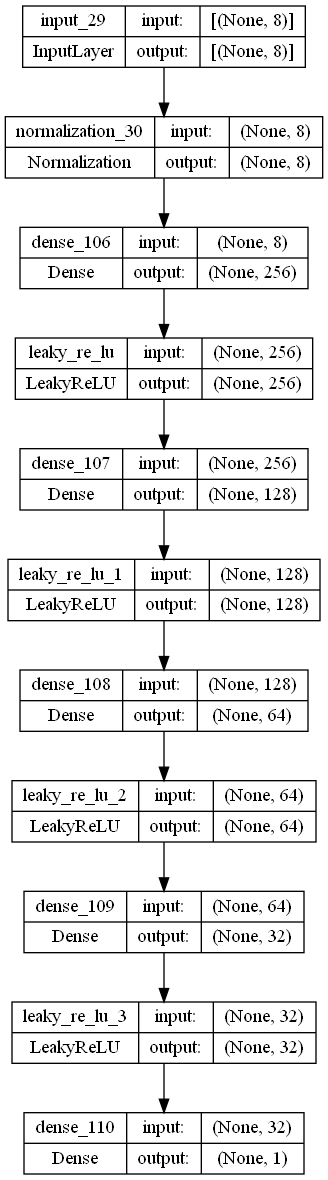

In [210]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [211]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_30 (Normaliza  (None, 8)                17        
 tion)                                                           
                                                                 
 dense_106 (Dense)           (None, 256)               2304      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 dense_107 (Dense)           (None, 128)               32896     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_108 (Dense)           (None, 64)                8256      
                                                     

In [214]:
model.compile(loss=MeanAbsoluteError(),optimizer=Adam(learning_rate=0.05),metrics=RootMeanSquaredError())

In [215]:
history = model.fit(train_dataset,validation_data=val_dataset,epochs=100,verbose=1)

Epoch 1/100
25/25 [==============================] - 4s 19ms/step - loss: 31211.0625 - root_mean_squared_error: 41347.6172 - val_loss: 43069.8555 - val_root_mean_squared_error: 52359.4609
Epoch 2/100
25/25 [==============================] - 0s 6ms/step - loss: 30204.9805 - root_mean_squared_error: 38492.4297 - val_loss: 39427.1602 - val_root_mean_squared_error: 47954.5859
Epoch 3/100
25/25 [==============================] - 0s 5ms/step - loss: 27599.2383 - root_mean_squared_error: 35644.4766 - val_loss: 39467.4336 - val_root_mean_squared_error: 47947.1172
Epoch 4/100
25/25 [==============================] - 0s 5ms/step - loss: 26687.1309 - root_mean_squared_error: 34700.9570 - val_loss: 39381.8203 - val_root_mean_squared_error: 48227.1367
Epoch 5/100
25/25 [==============================] - 0s 5ms/step - loss: 25805.4395 - root_mean_squared_error: 34000.4062 - val_loss: 40292.9258 - val_root_mean_squared_error: 48364.8047
Epoch 6/100
25/25 [==============================] - 0s 5ms/step

In [216]:
history.history

{'loss': [31211.0625,
  30204.98046875,
  27599.23828125,
  26687.130859375,
  25805.439453125,
  25256.775390625,
  27320.482421875,
  28094.26953125,
  25506.5703125,
  28183.544921875,
  27126.142578125,
  27497.501953125,
  24368.376953125,
  24851.240234375,
  25689.80078125,
  24571.119140625,
  24223.578125,
  23777.255859375,
  24514.634765625,
  23968.33203125,
  26630.48046875,
  26234.412109375,
  24101.009765625,
  23701.759765625,
  22586.6953125,
  24603.015625,
  28538.578125,
  28251.9140625,
  24677.607421875,
  25001.587890625,
  28268.375,
  24585.91796875,
  23358.3359375,
  25044.212890625,
  25115.025390625,
  24605.912109375,
  31908.84765625,
  29525.1015625,
  27167.23046875,
  32292.44921875,
  30344.244140625,
  25530.88671875,
  24685.734375,
  25874.79296875,
  36411.06640625,
  33654.921875,
  30461.953125,
  32309.990234375,
  36667.3828125,
  37210.7734375,
  31531.751953125,
  27400.580078125,
  25752.4296875,
  24203.830078125,
  23253.685546875,
  251

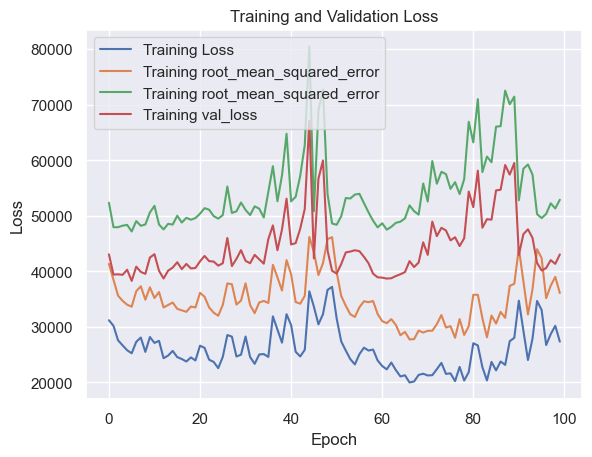

In [217]:
# Plot the training and validation loss
sns.set(style='darkgrid')
sns.lineplot(x=history.epoch, y=history.history['loss'], label='Training Loss')
sns.lineplot(x=history.epoch, y=history.history['root_mean_squared_error'], label='Training root_mean_squared_error')
sns.lineplot(x=history.epoch, y=history.history['val_root_mean_squared_error'], label='Training root_mean_squared_error')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='Training val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

In [219]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 6ms/step - loss: 49359.5781 - root_mean_squared_error: 60823.7070


[49359.578125, 60823.70703125]